<a href="https://colab.research.google.com/github/palver7/deeplearning/blob/master/FashionMNIST_with_ResNet152.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

In [0]:
from torchvision.datasets import FashionMNIST
import torch.optim as optim
from torch.optim import lr_scheduler
import torch
import torch.nn as nn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
from torch.utils.data import random_split,DataLoader
import os
import copy

plt.ion()

In [0]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.Grayscale(3), 
        transforms.ToTensor(), 
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.Grayscale(3),
        transforms.ToTensor(), 
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
}

trainset = FashionMNIST(root='./data', train=True, 
                        download=True, transform=data_transforms['train'])

trainset, valset = random_split(trainset, (50000,10000))

trainloader = DataLoader(trainset, batch_size=64, shuffle=True, 
                                          num_workers=4)

testset = FashionMNIST(root='./data', train=False, 
                       download=True,transform=data_transforms['test'])

testloader = DataLoader(testset, batch_size=64, shuffle=False, 
                                         num_workers=4)

valloader = DataLoader(valset, batch_size=64, shuffle=False, 
                                         num_workers=4)

class_names = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
           'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')


image_datasets = {'train': trainset, 'val': valset}
dataloaders = {'train': trainloader, 'val': valloader}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
def train_model(model, criterion, optimizer, scheduler, val_acc, 
                val_loss, train_acc, train_loss, 
                num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    list = {'train': {'acc': train_acc, 'loss': train_loss}, 
        'val':{'acc': val_acc, 'loss': val_loss}}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
        
            running_loss = 0.0
            running_corrects = 0
        
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
        
                # zero the parameter gradients
                optimizer.zero_grad()
        
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
        
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
        
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            list[phase]['loss'].append(epoch_loss)
            list[phase]['acc'].append(epoch_acc.item())
        
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
        
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
        
    # load best model weights
    model.load_state_dict(best_model_wts)
        
    return model

In [0]:
model = models.resnet152(pretrained=True)
for param in model.parameters():
    param.requires_grad = False


# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [0]:
# Lists for plotting loss and accuracy.
# Rerun this cell if you want to restart training to empty the lists.
val_acc = []
val_loss = []
train_acc = []
train_loss = []

In [0]:
model = train_model(model, criterion, optimizer, scheduler, val_acc, val_loss, 
                    train_acc, train_loss, num_epochs=5)

Epoch 0/4
----------
train Loss: 0.8230 Acc: 0.7568
val Loss: 0.5779 Acc: 0.8117

Epoch 1/4
----------
train Loss: 0.5502 Acc: 0.8153
val Loss: 0.5076 Acc: 0.8299

Epoch 2/4
----------
train Loss: 0.5053 Acc: 0.8275
val Loss: 0.4895 Acc: 0.8313

Epoch 3/4
----------
train Loss: 0.4810 Acc: 0.8326
val Loss: 0.4640 Acc: 0.8430

Epoch 4/4
----------
train Loss: 0.4654 Acc: 0.8370
val Loss: 0.4567 Acc: 0.8403

Training complete in 117m 30s
Best val Acc: 0.843000


Comparing training and validation accuracy and the training time of feature extraction (freezing the backpropagation), finetuning the model (use pretrained model, not freezing the backpropagation), and training the model from scratch ( no pretrained model).

###the feature extraction results are:

Epoch 0/4
----------
train Loss: 0.8230 Acc: 0.7568
val Loss: 0.5779 Acc: 0.8117

Epoch 1/4
----------
train Loss: 0.5502 Acc: 0.8153
val Loss: 0.5076 Acc: 0.8299

Epoch 2/4
----------
train Loss: 0.5053 Acc: 0.8275
val Loss: 0.4895 Acc: 0.8313

Epoch 3/4
----------
train Loss: 0.4810 Acc: 0.8326
val Loss: 0.4640 Acc: 0.8430

Epoch 4/4
----------
train Loss: 0.4654 Acc: 0.8370
val Loss: 0.4567 Acc: 0.8403

Training complete in 117m 30s
Best val Acc: 0.843000

In [0]:
val_acc = [0.8117,0.8229, 0.8313, 0.8430, 0.8403]
train_acc = [0.7568, 0.8153, 0.8275, 0.8326, 0.8370]
val_loss = [0.5779, 0.5076, 0.4895, 0.4640, 0.4567]
train_loss = [0.8230, 0.5502, 0.5053, 0.4810, 0.4654]

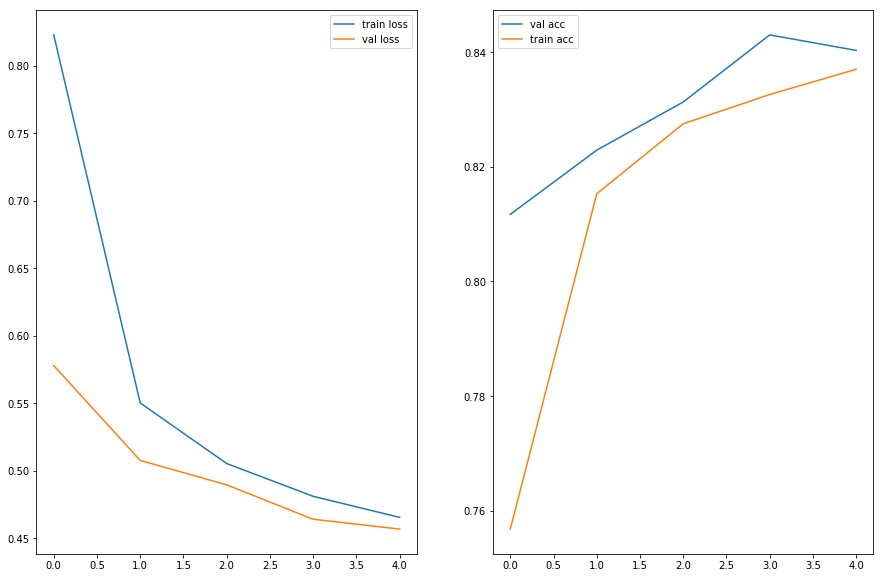

In [0]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
ax1.plot(train_loss, label='train loss')
ax1.plot(val_loss, label='val loss')
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='best')

ax2.plot(val_acc, label='val acc')
ax2.plot(train_acc, label='train acc')
ax2.legend()

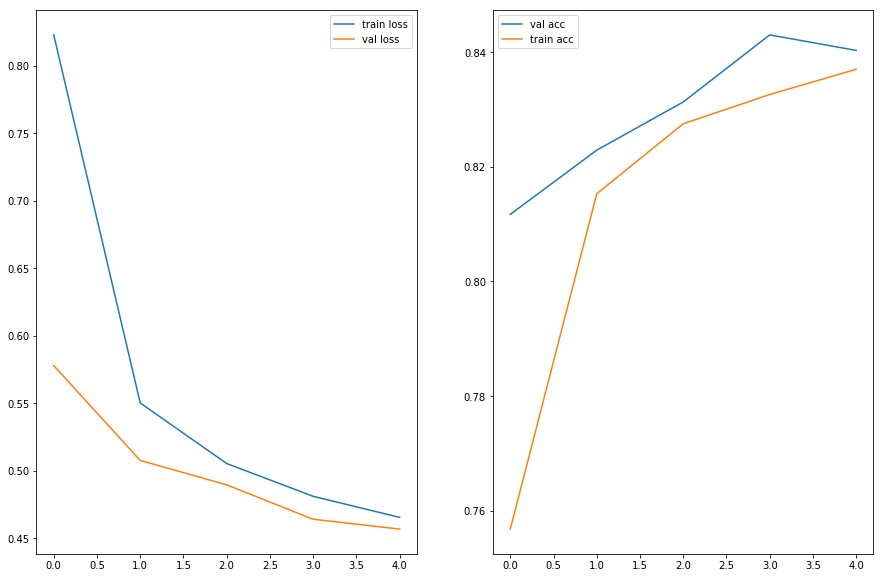

Feature extraction result using resnet 152.